# from Soham Pawar - Semantic Segmentation for Targeted Colorization Model Training right from scratch

- **Evaluation Metrics:**  
  This notebook evaluates the segmentation model using confusion matrix, precision, recall, and pixel accuracy. These metrics ensure that the model meets a minimum accuracy of 70%.

- **Model Creation Logic:**  
  The model is built from scratch using the VOCSegmentation dataset. The segmentation masks are converted into binary masks (background = 0, foreground = 1). A simple encoder–decoder architecture is used and the model is trained with binary cross entropy loss.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [2]:
# defining image transform
img_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# defineng mask transform (convert mask to binary)
def mask_transform(mask):
    # Resize
    mask = mask.resize((128,128), Image.NEAREST)
    mask = np.array(mask)
    # Convert to binary: background (0) and foreground (1)
    binary_mask = (mask > 0).astype(np.float32)
    return torch.from_numpy(binary_mask).unsqueeze(0)  # shape: (1, H, W)

# now creating a custom dataset using VOCSegmentation
class VOCDatasetBinary(Dataset):
    def __init__(self, root, image_set='train', transform=None, mask_transform=None):
        self.voc = VOCSegmentation(root=root, year='2012', image_set=image_set, download=True, transform=transform, target_transform=mask_transform)
    def __len__(self):
        return len(self.voc)
    def __getitem__(self, idx):
        image, mask = self.voc[idx]
        return image, mask
# and finally i create training and validation datasets
train_dataset = VOCDatasetBinary(root='./VOC2012', image_set='train', transform=img_transform, mask_transform=mask_transform)
val_dataset = VOCDatasetBinary(root='./VOC2012', image_set='val', transform=img_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

100%|██████████| 2.00G/2.00G [01:19<00:00, 25.3MB/s]


In [3]:
class SimpleSegmentationNet(nn.Module):
    def __init__(self):
        super(SimpleSegmentationNet, self).__init__()
        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 128 -> 64
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 64 -> 32
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 32 -> 16
        )
        # decoder
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16 -> 32
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 32 -> 64
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),  # 64 -> 128
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        d3 = self.dec3(x3)
        d2 = self.dec2(d3)
        d1 = self.dec1(d2)
        return d1

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSegmentationNet().to(device)

# Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"Training on device: {device}")

Training on device: cuda


In [5]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # binarize predictions at threshold 0.5
            preds = (outputs > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())
    val_loss /= len(val_loader.dataset)

    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_masks = np.concatenate(all_masks, axis=0).flatten()

    # here are the evaluation Metrics
    conf_matrix = confusion_matrix(all_masks, all_preds)
    acc = accuracy_score(all_masks, all_preds)
    prec = precision_score(all_masks, all_preds, zero_division=0)
    rec = recall_score(all_masks, all_preds, zero_division=0)

    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Validation Metrics: Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

Epoch 1/10 - Validation: 100%|██████████| 182/182 [00:07<00:00, 23.96it/s]


Epoch 1/10 -- Train Loss: 0.6019, Val Loss: 0.6352
Validation Metrics: Accuracy: 0.6925, Precision: 0.5623, Recall: 0.0011
Confusion Matrix:
[[16431562     6483]
 [ 7294044     8327]]


Epoch 2/10 - Validation: 100%|██████████| 182/182 [00:05<00:00, 30.81it/s]


Epoch 2/10 -- Train Loss: 0.5626, Val Loss: 0.5286
Validation Metrics: Accuracy: 0.7173, Precision: 0.5612, Recall: 0.3705
Confusion Matrix:
[[14323137  2114908]
 [ 4597090  2705281]]


Epoch 3/10 - Validation: 100%|██████████| 182/182 [00:07<00:00, 25.81it/s]


Epoch 3/10 -- Train Loss: 0.5433, Val Loss: 0.5256
Validation Metrics: Accuracy: 0.7232, Precision: 0.5824, Recall: 0.3542
Confusion Matrix:
[[14583020  1855025]
 [ 4715646  2586725]]


Epoch 4/10 - Validation: 100%|██████████| 182/182 [00:07<00:00, 25.83it/s]


Epoch 4/10 -- Train Loss: 0.5316, Val Loss: 0.5214
Validation Metrics: Accuracy: 0.7265, Precision: 0.5850, Recall: 0.3817
Confusion Matrix:
[[14460638  1977407]
 [ 4514975  2787396]]


Epoch 5/10 - Validation: 100%|██████████| 182/182 [00:05<00:00, 30.65it/s]


Epoch 5/10 -- Train Loss: 0.5301, Val Loss: 0.5218
Validation Metrics: Accuracy: 0.7228, Precision: 0.6155, Recall: 0.2633
Confusion Matrix:
[[15236752  1201293]
 [ 5379586  1922785]]


Epoch 6/10 - Validation: 100%|██████████| 182/182 [00:06<00:00, 29.83it/s]


Epoch 6/10 -- Train Loss: 0.5305, Val Loss: 0.5170
Validation Metrics: Accuracy: 0.7295, Precision: 0.6006, Recall: 0.3595
Confusion Matrix:
[[14692074  1745971]
 [ 4676818  2625553]]


Epoch 7/10 - Validation: 100%|██████████| 182/182 [00:07<00:00, 25.98it/s]


Epoch 7/10 -- Train Loss: 0.5272, Val Loss: 0.5166
Validation Metrics: Accuracy: 0.7298, Precision: 0.5620, Recall: 0.5500
Confusion Matrix:
[[13308373  3129672]
 [ 3285880  4016491]]


Epoch 8/10 - Validation: 100%|██████████| 182/182 [00:07<00:00, 25.89it/s]


Epoch 8/10 -- Train Loss: 0.5216, Val Loss: 0.5133
Validation Metrics: Accuracy: 0.7286, Precision: 0.6291, Recall: 0.2871
Confusion Matrix:
[[15202013  1236032]
 [ 5206116  2096255]]


Epoch 9/10 - Validation: 100%|██████████| 182/182 [00:05<00:00, 30.48it/s]


Epoch 9/10 -- Train Loss: 0.5200, Val Loss: 0.5138
Validation Metrics: Accuracy: 0.7366, Precision: 0.5841, Recall: 0.4993
Confusion Matrix:
[[13842523  2595522]
 [ 3656637  3645734]]


Epoch 10/10 - Validation: 100%|██████████| 182/182 [00:06<00:00, 27.48it/s]


Epoch 10/10 -- Train Loss: 0.5186, Val Loss: 0.5078
Validation Metrics: Accuracy: 0.7366, Precision: 0.5803, Recall: 0.5188
Confusion Matrix:
[[13697564  2740481]
 [ 3513786  3788585]]


In [6]:
torch.save(model.state_dict(), "segmentation_model_weights.pth")
torch.save(model, "segmentation_model_complete.pth")
print("Model saved as segmentation_model_weights.pth and segmentation_model_complete.pth")

Model saved as segmentation_model_weights.pth and segmentation_model_complete.pth


## Downloading the Saved Files
only for colab userss.

In [7]:
try:
    from google.colab import files
    files.download("segmentation_model_weights.pth")
    files.download("segmentation_model_complete.pth")
except ImportError:
    print("Not running in Colab; skipping file download step.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

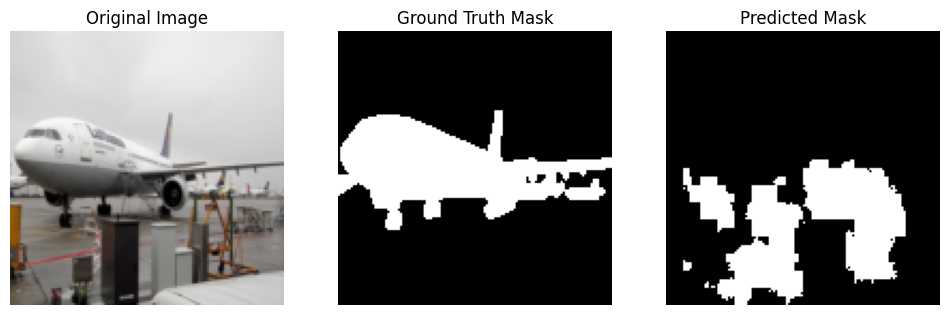

In [8]:
model.eval()
with torch.no_grad():
    sample_img, sample_mask = val_dataset[0]
    sample_img_tensor = sample_img.unsqueeze(0).to(device)
    pred_mask = model(sample_img_tensor).cpu().squeeze(0)
    pred_mask_bin = (pred_mask > 0.5).float()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(np.transpose(sample_img.numpy(), (1,2,0)))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(sample_mask.squeeze(0), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred_mask_bin.squeeze(0), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()